In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
player_salary_data = pd.read_csv("data/player_salaries_with_positions.csv")

In [3]:
player_salary_data.head()

,player_name,salary,salary_inflation_adj,team,regular_season,cleaned_names,PLAYER_ID,HEIGHT,WEIGHT,POSITION,five_positions,three_positions,salary_pct_of_cap
0,A.C. Green,1750000.0,3450733.0,Los Angeles Lakers,1990,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.147418
1,A.C. Green,1750000.0,3295957.0,Los Angeles Lakers,1991,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.140000
2,A.C. Green,1750000.0,3197220.0,Los Angeles Lakers,1992,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.125000
3,A.C. Green,1885000.0,3343694.0,Phoenix Suns,1993,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.124217
4,A.C. Green,6472600.0,11202102.0,Phoenix Suns,1994,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.405450


# Cleaning Positions

The NBA uses G / F / C nomenclature for their positions, while realgm.com uses a mix of things, so I need to get them all onto the same position map. Due to most of the data being from stats.nba.com, I am going to use the G / F / C positions.

TO-DO: use guard / wing / big instead of G / F / C

In [78]:
mixed_to_five_position_map = {
    "Forward-Center": "PF",
    "Guard-Forward": "SG",
    "Forward-Guard": "SF",
    "Center-Forward": "C"
}

five_to_three_position_map = {
    "PG": "Guard",
    "SG": "Guard",
    "SF": "Forward",
    "PF": "Forward",
    "C": "Center"
}

In [79]:
player_salary_data["five_positions"] = player_salary_data.POSITION.apply(
    lambda x: mixed_to_five_position_map[x] if x in mixed_to_five_position_map else x
)
player_salary_data.five_positions.unique()

array(['Forward', 'C', 'Guard', 'Center', 'PG', 'PF', 'SG', 'SF'],
      dtype=object)

In [80]:
player_salary_data["three_positions"] = player_salary_data.five_positions.apply(
    lambda x: five_to_three_position_map[x] if x in five_to_three_position_map else x
)
player_salary_data.three_positions.unique()

array(['Forward', 'Center', 'Guard'], dtype=object)

# Missing Player Salary Seasons

In [81]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].shape[0]

493

In [82]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].cleaned_names.nunique()

395

There are 395 unique players with missing salary seasons, and 493 total instances of missing salary seasons.

In [83]:
player_salary_data.loc[
    player_salary_data.player_name.isna()
].groupby("regular_season").PLAYER_ID.count()

regular_season
1990    39
1991    33
1992    27
1993    44
1994    28
1995    22
1996    46
1997    34
1998    26
1999     9
2000    17
2001    17
2002    12
2003    24
2004    24
2005    13
2006     6
2007     9
2008     5
2009     6
2010     7
2011    24
2012     2
2013    11
2014     4
2015     1
2016     3
Name: PLAYER_ID, dtype: int64

As we can see, most of the missing salaries are from 2005 and before. The high number of missing salaries from 2011 is likely due to the lockout shortened season.

# Graphing It

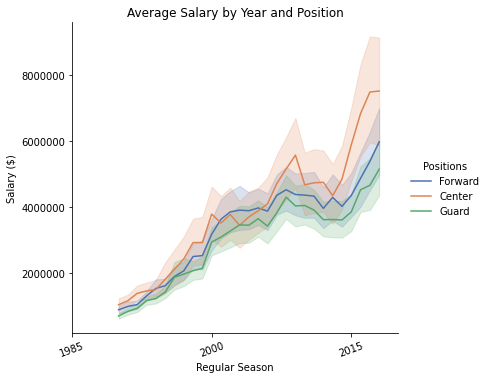

In [84]:
g = sns.relplot(
    x="regular_season",
    y="salary",
    kind="line",
    hue="three_positions",
    data=player_salary_data,
    palette="deep"
)

g.set_xticklabels(step = 3, rotation=20)
sns.utils.plt.ticklabel_format(style='plain', axis='y',useOffset=False)
g.set(
    title="Average Salary by Year and Position", 
    xlabel="Regular Season",
    ylabel="Salary ($)",
)
g._legend.set_title("Positions")
#g.savefig("data/salary_by_year_and_position_basic_line.png")

In [85]:
position_yearly_salary_pct = (
    player_salary_data.groupby(
        ["regular_season", "three_positions"]
    ).salary.sum() / player_salary_data.groupby(
        ["regular_season"]
    ).salary.sum()
).reset_index().rename(columns={"salary":"salary_pct"})

In [86]:
position_yearly_salary_pct

,regular_season,three_positions,salary_pct
0,1990,Center,0.284625
1,1990,Forward,0.399154
2,1990,Guard,0.316221
3,1991,Center,0.272616
4,1991,Forward,0.391794
...,...,...,...
82,2017,Forward,0.381816
83,2017,Guard,0.421704
84,2018,Center,0.185866
85,2018,Forward,0.389913


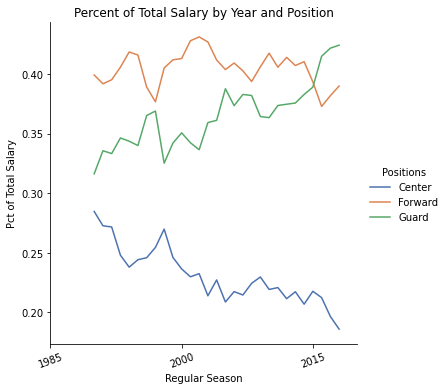

In [87]:
g = sns.relplot(
    x="regular_season",
    y="salary_pct",
    kind="line",
    hue="three_positions",
    data=position_yearly_salary_pct,
    palette="deep"
)

g.set_xticklabels(step = 3, rotation=20)
sns.utils.plt.ticklabel_format(style='plain', axis='y',useOffset=False)
g.set(
    title="Percent of Total Salary by Year and Position", 
    xlabel="Regular Season",
    ylabel="Pct of Total Salary",
)
g._legend.set_title("Positions")

In [88]:
grp_season_salary_data = player_salary_data.groupby("regular_season")

position_yearly_contract_pct = (
    grp_season_salary_data.three_positions.value_counts() / grp_season_salary_data.salary.count()
).reset_index().rename(columns={0:"pct_of_contracts"})

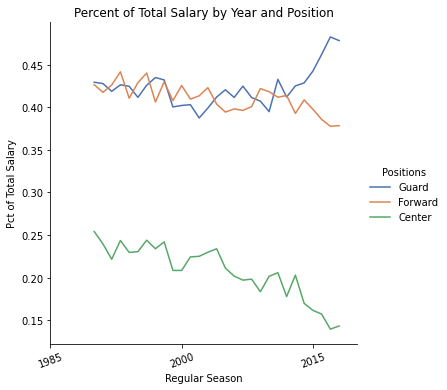

In [89]:
g = sns.relplot(
    x="regular_season",
    y="pct_of_contracts",
    kind="line",
    hue="three_positions",
    data=position_yearly_contract_pct,
    palette="deep"
)

g.set_xticklabels(step = 3, rotation=20)
sns.utils.plt.ticklabel_format(style='plain', axis='y',useOffset=False)
g.set(
    title="Percent of Total Salary by Year and Position", 
    xlabel="Regular Season",
    ylabel="Pct of Total Salary",
)
g._legend.set_title("Positions")

# Adding in Salary Cap

In [90]:
salary_caps = pd.read_csv("data/NBA_yearly_salary_caps.csv")

In [91]:
print(salary_caps.shape[0])
salary_caps.head()

45


,Season,Salary Cap,Luxury Tax,BAE,Standard /Non-Taxpayer MLE,Taxpayer MLE,Team Room /Under Cap MLE
0,2027-2028,167513000,202355000.0,5562000.0,14210000.0,8776000.0,7317000.0
1,2026-2027,159536000,192719000.0,5297000.0,13533000.0,8358000.0,6969000.0
2,2025-2026,151939000,183542000.0,5045000.0,12889000.0,7960000.0,6637000.0
3,2024-2025,144704000,174802000.0,4805000.0,12275000.0,7581000.0,6321000.0
4,2023-2024,137813000,166478000.0,4576000.0,11690000.0,7220000.0,6020000.0


In [92]:
salary_caps["regular_season"] = salary_caps.Season.apply(lambda x: x.split("-")[0]).astype(int)

In [93]:
season_salary_cap_map = salary_caps.set_index("regular_season")["Salary Cap"]

Now part of the original CSV

In [94]:
if 1 == 0:
    player_salary_data["salary_pct_of_cap"] = player_salary_data.apply(
        lambda x: x.salary / season_salary_cap_map[x.regular_season], axis=1
    )

Need to multiply denominator by # of teams

In [95]:
num_unique_teams = player_salary_data.groupby("regular_season").team.nunique()

Can delete?

In [22]:
foo = player_salary_data.groupby(
        ["regular_season", "three_positions"]
    ).salary.sum().reset_index()
foo.merge(season_salary_cap_map, on="regular_season").assign(pct_of_salary_cap = lambda x: x.salary / x["Salary Cap"]).head()

,regular_season,three_positions,salary,Salary Cap,pct_of_salary_cap
0,1990,Center,83840000.0,11871000,7.062590
1,1990,Forward,117576000.0,11871000,9.904473
2,1990,Guard,93147000.0,11871000,7.846601
3,1991,Center,100754000.0,12500000,8.060320
4,1991,Forward,144800000.0,12500000,11.584000


# By Height and Weight
How to incorporate the time factor?

In [23]:
player_salary_data.head()

,player_name,salary,salary_inflation_adj,team,regular_season,cleaned_names,PLAYER_ID,HEIGHT,WEIGHT,POSITION,five_positions,three_positions,salary_pct_of_cap
0,A.C. Green,1750000.0,3450733.0,Los Angeles Lakers,1990,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.147418
1,A.C. Green,1750000.0,3295957.0,Los Angeles Lakers,1991,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.140000
2,A.C. Green,1750000.0,3197220.0,Los Angeles Lakers,1992,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.125000
3,A.C. Green,1885000.0,3343694.0,Phoenix Suns,1993,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.124217
4,A.C. Green,6472600.0,11202102.0,Phoenix Suns,1994,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.405450


<AxesSubplot:xlabel='HEIGHT'>

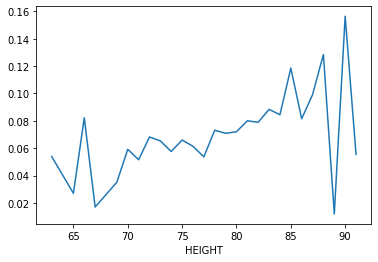

In [96]:
player_salary_data.groupby("HEIGHT").salary_pct_of_cap.mean().plot()

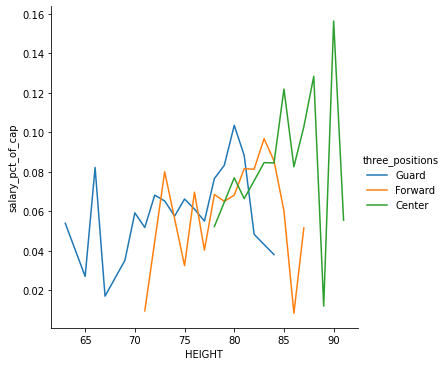

In [97]:
d = player_salary_data.groupby(["HEIGHT", "three_positions"]).salary_pct_of_cap.mean().reset_index().rename(columns={0:"salary_pct_of_cap"})

sns.relplot(
    x="HEIGHT",
    y="salary_pct_of_cap",
    data=d,
    hue="three_positions",
    kind="line"
)

<AxesSubplot:xlabel='WEIGHT'>

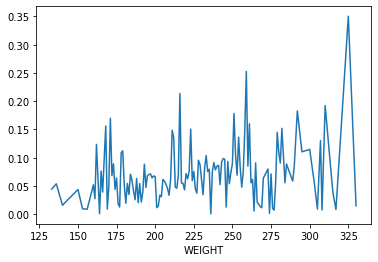

In [98]:
player_salary_data.groupby("WEIGHT").salary_pct_of_cap.mean().plot()

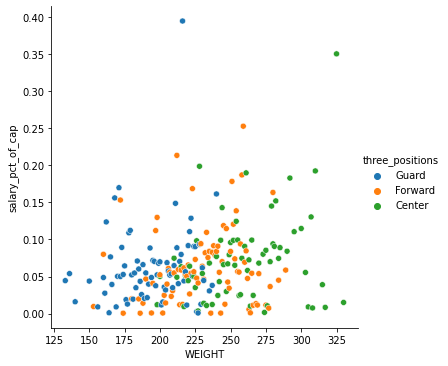

In [99]:
d = player_salary_data.groupby(["WEIGHT", "three_positions"]).salary_pct_of_cap.mean().reset_index().rename(columns={0:"salary_pct_of_cap"})

sns.relplot(
    x="WEIGHT",
    y="salary_pct_of_cap",
    data=d,
    hue="three_positions",
#     kind="line"
)

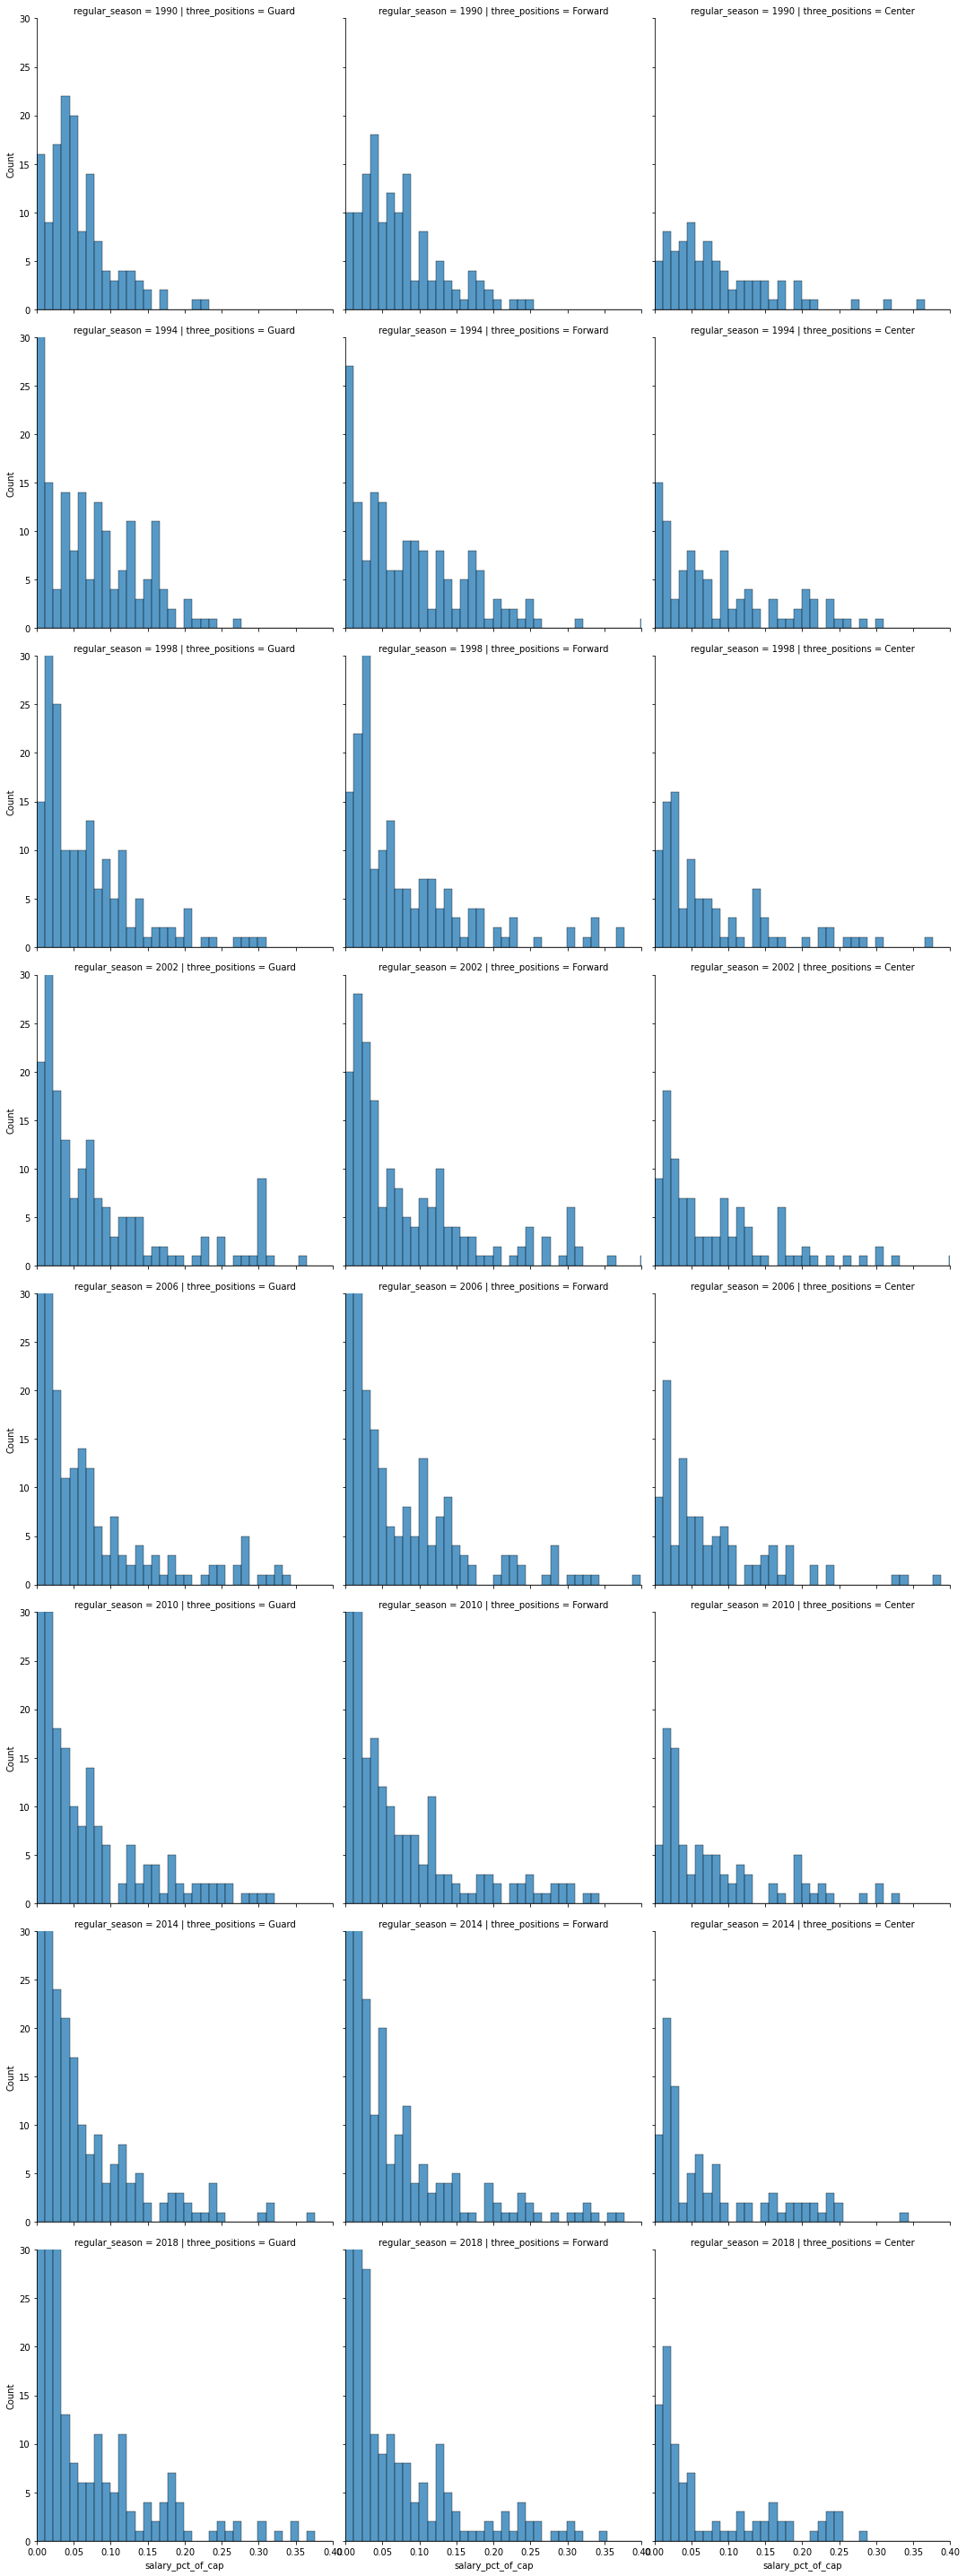

In [100]:
g = sns.displot(
    kind="hist",
    x="salary_pct_of_cap",
    row="regular_season",
    col="three_positions",
    col_order=["Guard", "Forward", "Center"],
    data=player_salary_data.loc[(player_salary_data.regular_season - 1990) % 4 == 0]
)

g.set(ylim=(0, 30), xlim=(0, 0.4))

Need some sense of the distribution for these. Add KDE?

# Adding in Age

Need to bring in age from player profiles - will probably have decent amount of missing data because of players not having NBA IDs.

In [101]:
import re
def col_str_to_list(column):
    return re.sub(r"\[|'|\]", "", column).split(', ')

common_player_info = pd.read_csv("data/player_common_player_info.csv")
player_headlines = pd.read_csv("data/player_player_headlines.csv")
player_seasons = pd.read_csv("data/player_player_seasons.csv", 
                             converters={
                                 "regular_seasons": col_str_to_list,
                                 "playoff_seasons": col_str_to_list,
                                 "gleague_seasons": col_str_to_list,
                                 "all_star_seasons": col_str_to_list
                             })

In [102]:
common_player_info.columns

Index(['DRAFT_YEAR', 'DISPLAY_LAST_COMMA_FIRST', 'TEAM_CODE', 'SCHOOL',
       'DLEAGUE_FLAG', 'DISPLAY_FI_LAST', 'TO_YEAR', 'TEAM_ABBREVIATION',
       'LAST_AFFILIATION', 'JERSEY', 'PLAYERCODE', 'POSITION', 'DRAFT_NUMBER',
       'WEIGHT', 'HEIGHT', 'BIRTHDATE', 'LAST_NAME', 'DISPLAY_FIRST_LAST',
       'TEAM_CITY', 'FIRST_NAME', 'TEAM_ID', 'PERSON_ID', 'COUNTRY',
       'FROM_YEAR', 'SEASON_EXP', 'DRAFT_ROUND', 'NBA_FLAG',
       'GAMES_PLAYED_FLAG', 'TEAM_NAME', 'ROSTERSTATUS'],
      dtype='object')

In [103]:
common_player_info.loc[:, ["DISPLAY_LAST_COMMA_FIRST", "BIRTHDATE", "PERSON_ID"]].head()

,DISPLAY_LAST_COMMA_FIRST,BIRTHDATE,PERSON_ID
0,"Abdelnaby, Alaa",1968-06-24T00:00:00,76001
1,"Abdul-Aziz, Zaid",1946-04-07T00:00:00,76002
2,"Abdul-Jabbar, Kareem",1947-04-16T00:00:00,76003
3,"Abdul-Rauf, Mahmoud",1969-03-09T00:00:00,51
4,"Abdul-Wahad, Tariq",1974-11-03T00:00:00,1505


In [104]:
from datetime import date

In [105]:
player_salary_data = player_salary_data.merge(
    common_player_info.loc[:, ["PERSON_ID", "BIRTHDATE"]].rename(columns={"PERSON_ID":"PLAYER_ID"}),
    how="left",
    on="PLAYER_ID"
)

player_salary_data["season_age_date_estimator"] = player_salary_data.regular_season.apply(lambda x: date(x, 2, 1))

player_salary_data["season_age"] = (
    (pd.to_datetime(player_salary_data.season_age_date_estimator) - pd.to_datetime(player_salary_data.BIRTHDATE)).dt.days / 365
).round(2)

In [106]:
player_salary_data.groupby(["season_age", "three_positions"]).salary_pct_of_cap.mean()

season_age  three_positions
17.28       Center             0.038155
17.32       Center             0.033945
17.45       Forward            0.041662
17.63       Center             0.082021
17.71       Guard              0.050534
                                 ...   
41.66       Center             0.054647
41.86       Forward            0.011324
42.45       Center             0.041046
43.44       Center                  NaN
43.45       Center             0.042751
Name: salary_pct_of_cap, Length: 4652, dtype: float64

In [107]:
salary_age_data = player_salary_data.groupby(["season_age", "three_positions"]).salary_pct_of_cap.mean().reset_index()

In [50]:
player_salary_data.head()

,player_name,salary,salary_inflation_adj,team,regular_season,cleaned_names,PLAYER_ID,HEIGHT,WEIGHT,POSITION,five_positions,three_positions,salary_pct_of_cap,BIRTHDATE,season_age_date_estimator,season_age
0,A.C. Green,1750000.0,3450733.0,Los Angeles Lakers,1990,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.147418,1963-10-04T00:00:00,1990-02-01,26.35
1,A.C. Green,1750000.0,3295957.0,Los Angeles Lakers,1991,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.140000,1963-10-04T00:00:00,1991-02-01,27.35
2,A.C. Green,1750000.0,3197220.0,Los Angeles Lakers,1992,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.125000,1963-10-04T00:00:00,1992-02-01,28.35
3,A.C. Green,1885000.0,3343694.0,Phoenix Suns,1993,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.124217,1963-10-04T00:00:00,1993-02-01,29.35
4,A.C. Green,6472600.0,11202102.0,Phoenix Suns,1994,AC Green,920.0,81,225.0,Forward,Forward,Forward,0.405450,1963-10-04T00:00:00,1994-02-01,30.35


In [49]:
player_salary_data.shape

(14544, 16)

In [36]:
salary_age_data.head()

,season_age,three_positions,salary_pct_of_cap
0,17.28,Center,0.038155
1,17.32,Center,0.033945
2,17.45,Forward,0.041662
3,17.63,Center,0.082021
4,17.71,Guard,0.050534


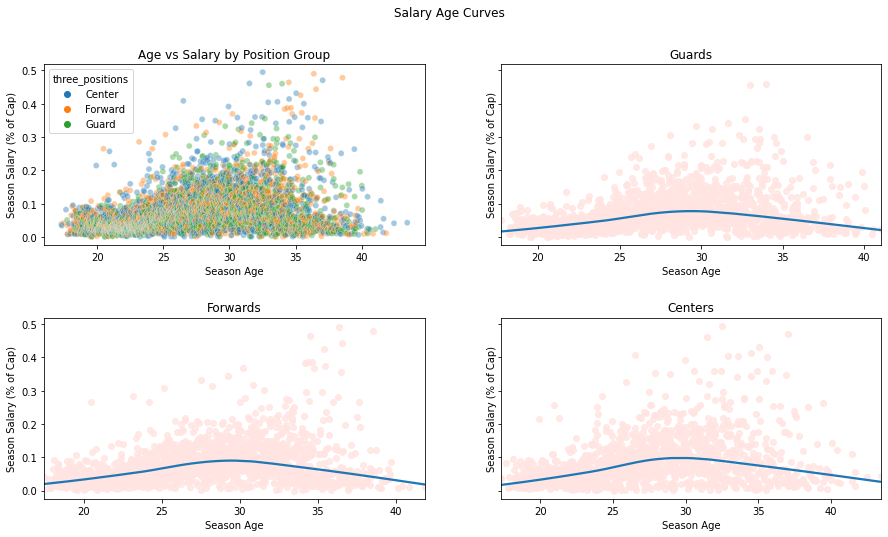

In [227]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharey=True)
fig.suptitle("Salary Age Curves")
plt.subplots_adjust(wspace=0.2, hspace=0.4)

sns.scatterplot(
    data=salary_age_data,
    x="season_age", y="salary_pct_of_cap",
    hue="three_positions",
    alpha=0.4,
    ax=ax[0, 0]
)
ax[0, 0].set_title("Age vs Salary by Position Group")
ax[0, 0].set_xlabel("Season Age")
ax[0, 0].set_ylabel("Season Salary (% of Cap)")

sns.regplot(
    data = salary_age_data.loc[salary_age_data.three_positions=="Guard"],
    x="season_age",
    y="salary_pct_of_cap",
    lowess=True,
    scatter_kws={"color":"mistyrose"},
    ax=ax[0, 1]
)
ax[0, 1].set_title("Guards")
ax[0, 1].set_xlabel("Season Age")
ax[0, 1].set_ylabel("Season Salary (% of Cap)")

sns.regplot(
    data = salary_age_data.loc[salary_age_data.three_positions=="Forward"],
    x="season_age",
    y="salary_pct_of_cap",
    lowess=True,
    scatter_kws={"color":"mistyrose"},
    ax = ax[1, 0]
)

ax[1, 0].set_title("Forwards")
ax[1, 0].set_xlabel("Season Age")
ax[1, 0].set_ylabel("Season Salary (% of Cap)")

sns.regplot(
    data = salary_age_data.loc[salary_age_data.three_positions=="Center"],
    x="season_age",
    y="salary_pct_of_cap",
    lowess=True,
    scatter_kws={"color":"mistyrose"},
    ax=ax[1,1]
)
ax[1, 1].set_title("Centers")
ax[1, 1].set_xlabel("Season Age")
ax[1, 1].set_ylabel("Season Salary (% of Cap)")

plt.savefig("outputs/salary_age_curves.png")

## Compiling Average Salary by Anthropometric data

In [113]:
player_salary_data["BMI"] = player_salary_data.apply(lambda row: 703.0*(row.WEIGHT / row.HEIGHT**2), axis=1)

In [133]:
salary_ht_data = player_salary_data.groupby(
    ["HEIGHT", "three_positions"]
).salary_pct_of_cap.agg(["mean", "count"]).reset_index()

salary_wt_data = player_salary_data.groupby(
    ["WEIGHT", "three_positions"]
).salary_pct_of_cap.agg(["mean", "count"]).reset_index()

salary_bmi_data = player_salary_data.groupby(
    ["BMI", "three_positions"]
).salary_pct_of_cap.agg(["mean", "count"]).reset_index()

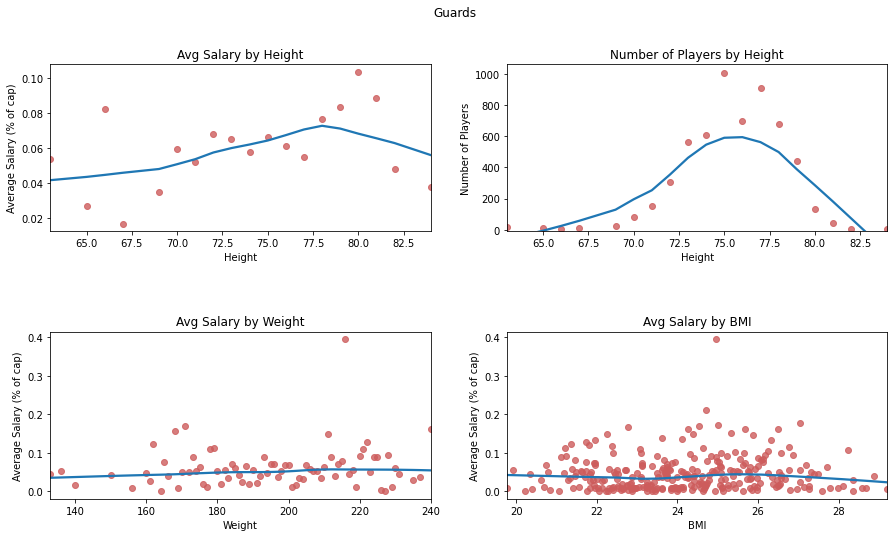

In [215]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Guards")
# fig.tight_layout(h_pad=4)
plt.subplots_adjust(wspace=0.2, hspace=0.6)

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Guard"],
    x="HEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 0]
)
ax[0, 0].set_title("Avg Salary by Height")
ax[0, 0].set_xlabel("Height")
ax[0, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Guard"],
    x="HEIGHT",
    y="count",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 1]
)
ax[0, 1].set_title("Number of Players by Height")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Number of Players")
ax[0, 1].set_ylim(bottom=-10)

sns.regplot(
    data = salary_wt_data.loc[salary_wt_data.three_positions=="Guard"],
    x="WEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 0]
)
ax[1, 0].set_title("Avg Salary by Weight")
ax[1, 0].set_xlabel("Weight")
ax[1, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_bmi_data.loc[salary_bmi_data.three_positions=="Guard"],
    x="BMI",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 1]
)
ax[1, 1].set_title("Avg Salary by BMI")
ax[1, 1].set_xlabel("BMI")
ax[1, 1].set_ylabel("Average Salary (% of cap)")

plt.savefig("outputs/guards_avg_salary_graphs.png")

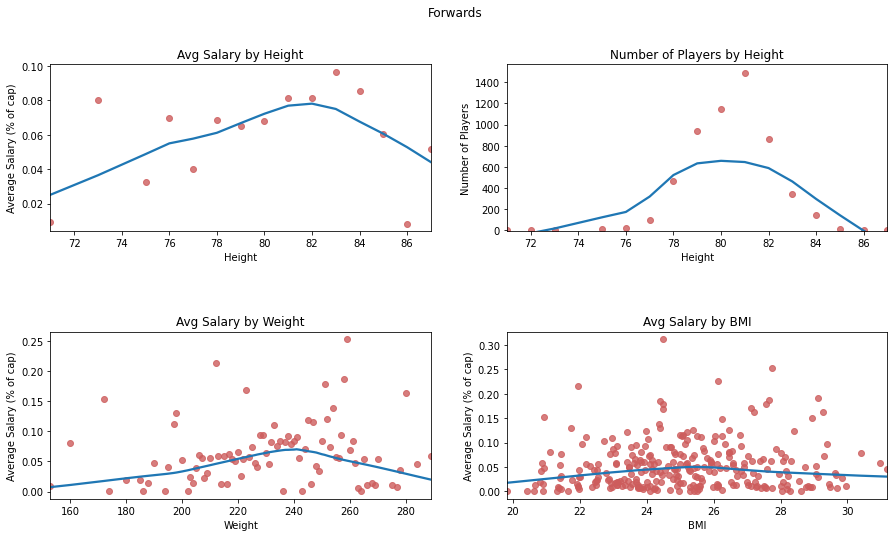

In [216]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Forwards")
# fig.tight_layout(h_pad=4)
plt.subplots_adjust(wspace=0.2, hspace=0.6)

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Forward"],
    x="HEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 0]
)
ax[0, 0].set_title("Avg Salary by Height")
ax[0, 0].set_xlabel("Height")
ax[0, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Forward"],
    x="HEIGHT",
    y="count",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 1]
)
ax[0, 1].set_title("Number of Players by Height")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Number of Players")
ax[0, 1].set_ylim(bottom=-10)

sns.regplot(
    data = salary_wt_data.loc[salary_wt_data.three_positions=="Forward"],
    x="WEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 0]
)
ax[1, 0].set_title("Avg Salary by Weight")
ax[1, 0].set_xlabel("Weight")
ax[1, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_bmi_data.loc[salary_bmi_data.three_positions=="Forward"],
    x="BMI",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 1]
)
ax[1, 1].set_title("Avg Salary by BMI")
ax[1, 1].set_xlabel("BMI")
ax[1, 1].set_ylabel("Average Salary (% of cap)")

plt.savefig("outputs/forwards_avg_salary_graphs.png")

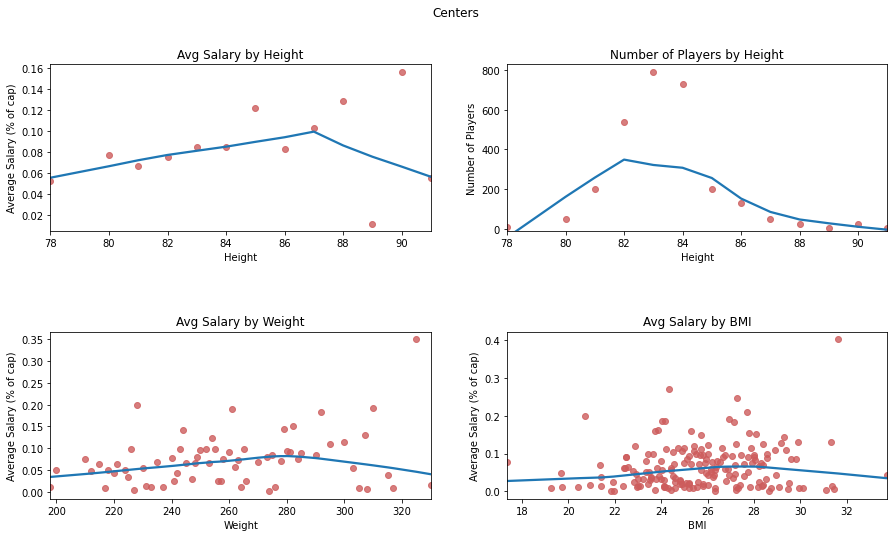

In [217]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Centers")
# fig.tight_layout(h_pad=4)
plt.subplots_adjust(wspace=0.2, hspace=0.6)

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Center"],
    x="HEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 0]
)
ax[0, 0].set_title("Avg Salary by Height")
ax[0, 0].set_xlabel("Height")
ax[0, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_ht_data.loc[salary_ht_data.three_positions=="Center"],
    x="HEIGHT",
    y="count",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[0, 1]
)
ax[0, 1].set_title("Number of Players by Height")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Number of Players")
ax[0, 1].set_ylim(bottom=-10)

sns.regplot(
    data = salary_wt_data.loc[salary_wt_data.three_positions=="Center"],
    x="WEIGHT",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 0]
)
ax[1, 0].set_title("Avg Salary by Weight")
ax[1, 0].set_xlabel("Weight")
ax[1, 0].set_ylabel("Average Salary (% of cap)")

sns.regplot(
    data = salary_bmi_data.loc[salary_bmi_data.three_positions=="Center"],
    x="BMI",
    y="mean",
    lowess=True,
    scatter_kws={"color":"indianred"},
    ax=ax[1, 1]
)
ax[1, 1].set_title("Avg Salary by BMI")
ax[1, 1].set_xlabel("BMI")
ax[1, 1].set_ylabel("Average Salary (% of cap)")

plt.savefig("outputs/centers_avg_salary_graphs.png")

**Average player start and end**

In [208]:
player_salary_data.groupby(["PLAYER_ID", "player_name"]).season_age.min().mean()

22.815382365231926

In [209]:
player_salary_data.groupby(["PLAYER_ID", "player_name"]).season_age.max().mean()

27.712687003760966

# Adding in Salary Metadata

- https://basketball.realgm.com/nba/info/minimum_scale/2017
- https://basketball.realgm.com/nba/info/rookie_scale

In [43]:
player_salary_data.columns

Index(['player_name', 'salary', 'salary_inflation_adj', 'team',
       'regular_season', 'cleaned_names', 'PLAYER_ID', 'HEIGHT', 'WEIGHT',
       'POSITION', 'five_positions', 'three_positions', 'salary_pct_of_cap',
       'BIRTHDATE', 'season_age_date_estimator', 'season_age'],
      dtype='object')

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
lr = LinearRegression()

lr_data = player_salary_data.dropna(axis=0)

X = lr_data[["HEIGHT", "salary_pct_of_cap"]]
y = lr_data.WEIGHT

In [ ]:
lr.fit(X, y)

In [ ]:
lr.coef_

In [ ]:
lr.intercept_

In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, train_size=0.75)

In [ ]:
lr.fit(X_tr, y_tr)

In [ ]:
preds = lr.predict(X_test)

In [ ]:
mean_squared_error(y_test, preds, squared=False)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
rr = Ridge()

In [ ]:
rr.fit(X_tr, y_tr)
rr_preds = rr.predict(X_test)
mean_squared_error(y_test, rr_preds, squared=False)